# Can you predict which NBA players will make the "All-Star" team?

## Part one: Clean the data

#### Import libraries

In [95]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from copy import copy, deepcopy
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

#### Load 'player_data.csv' 

In [2]:
player_data = pd.read_csv('./player_data.csv')

#### Drop the first column

In [3]:
player_data = player_data.drop(columns='Unnamed: 0')

#### Remove null values from "Players" column

In [4]:
player_data.dropna(subset=['Player'], inplace=True)

In [5]:
sum(player_data['Player'].isnull())

0

#### Replace null values with 0's in the '3P%' column

In [6]:
player_data['3P%'].fillna(0, inplace=True)

In [7]:
sum(player_data['3P%'].isnull())

0

#### Remove rows for players who started their careers before the 1980 season

In [8]:
#Series with names of players and their debut year
bf_1980 = player_data.groupby(by='Player').min()['Year']

#List of the name of player who started their careers before the 1980 season
names_bf_1980 = list(bf_1980[bf_1980<1980].reset_index()['Player'])

#Filtering the dataframe
player_data = player_data[player_data['Player'].isin(names_bf_1980) == False]

In [9]:
#Checking that there are no rows that do not meet the condition
player_data['Year'].min()

1980.0

In [10]:
player_data

,Year,Player,Pos,Age,Tm,G,PER,TS%,ORB%,DRB%,...,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PTS
5733,1980.0,James Bailey,PF,22.0,SEA,67.0,12.3,0.495,10.2,18.3,...,0.000,0.450,0.450,0.673,197.0,28.0,21.0,54.0,79.0,312.0
5741,1980.0,Billy Ray,SG,23.0,POR,16.0,24.1,0.552,6.0,7.6,...,0.421,0.504,0.521,0.718,29.0,31.0,14.0,2.0,20.0,180.0
5748,1980.0,Larry Bird*,PF,23.0,BOS,82.0,20.5,0.538,8.3,23.6,...,0.406,0.481,0.494,0.836,852.0,370.0,143.0,53.0,263.0,1745.0
5753,1980.0,Lawrence Boston,PF,23.0,WSB,13.0,12.6,0.485,15.1,16.2,...,0.000,0.462,0.462,0.615,39.0,2.0,4.0,2.0,8.0,56.0
5759,1980.0,Dudley Bradley,SG,22.0,IND,82.0,13.5,0.502,3.4,8.1,...,0.400,0.452,0.453,0.782,223.0,252.0,211.0,48.0,166.0,688.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,16.7,0.604,8.6,17.3,...,0.000,0.572,0.571,0.679,405.0,99.0,62.0,58.0,65.0,639.0
24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,13.0,0.508,9.2,17.0,...,0.000,0.497,0.494,0.564,124.0,42.0,7.0,21.0,20.0,178.0
24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,7.3,0.346,10.8,24.9,...,0.000,0.323,0.323,0.600,35.0,4.0,2.0,5.0,3.0,23.0
24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,6.9,0.503,1.9,14.2,...,0.333,0.451,0.473,0.775,125.0,36.0,15.0,16.0,40.0,240.0


#### Load in the 'all_star_appearances.pickle' file and use this data to create a column called 'all_star' that indicates whether or not a player made the All-Star team for a given year
- This file is a dictionary in which the keys are players who've made an All-Star team in their careers
- The values are all the years that the corresponding player made an All-Star team

#### Make sure this column is binary where 1 = Made All-Star team, and 0 = Did not make All-Star team

In [11]:
infile = open('./all_star_appearances.pickle','rb')
all_star = pickle.load(infile)
infile.close()

In [12]:
player_data['all_star'] = player_data.apply(lambda x: 1 if x.Year in all_star[x.Player] else 0,axis = 1)

In [13]:
all_star

defaultdict(set,
            {'Julius Erving': {1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987},
             'Jack Sikma': {1980, 1981, 1982, 1983, 1984, 1985},
             'Dan Roundfield': {1980, 1981, 1982},
             'Dennis Johnson': {1980, 1981, 1982, 1985},
             'Tiny Archibald': {1980, 1981, 1982},
             'Kareem Abdul-Jabbar': {1980,
              1981,
              1982,
              1983,
              1984,
              1985,
              1986,
              1987,
              1988,
              1989},
             'Eddie Johnson': {1980, 1981},
             'Otis Birdsong': {1980, 1981, 1984},
             'Magic Johnson': {1980,
              1982,
              1983,
              1984,
              1985,
              1986,
              1987,
              1988,
              1989,
              1990,
              1991,
              1992},
             'Kermit Washington': {1980},
             'Bill Cartwright': {1980},
             'John Dr

In [14]:
player_data[player_data['Player'] == 'Magic Johnson*']

,Year,Player,Pos,Age,Tm,G,PER,TS%,ORB%,DRB%,...,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PTS,all_star
5889,1980.0,Magic Johnson*,SG,20.0,LAL,77.0,20.6,0.602,7.1,15.4,...,0.540,0.534,0.810,596.0,563.0,187.0,41.0,305.0,1387.0,0
6247,1981.0,Magic Johnson*,SG,21.0,LAL,37.0,25.7,0.582,8.5,16.4,...,0.542,0.534,0.760,320.0,317.0,127.0,27.0,143.0,798.0,0
6611,1982.0,Magic Johnson*,SG,22.0,LAL,78.0,22.9,0.590,9.5,17.5,...,0.546,0.540,0.760,751.0,743.0,208.0,34.0,286.0,1447.0,0
6983,1983.0,Magic Johnson*,SG,23.0,LAL,79.0,23.0,0.603,8.5,17.1,...,0.560,0.548,0.800,683.0,829.0,176.0,47.0,301.0,1326.0,0
7348,1984.0,Magic Johnson*,PG,24.0,LAL,67.0,22.6,0.628,4.7,16.1,...,0.579,0.569,0.810,491.0,875.0,150.0,49.0,306.0,1178.0,0
7699,1985.0,Magic Johnson*,PG,25.0,LAL,77.0,23.2,0.637,4.1,14.4,...,0.577,0.565,0.843,476.0,968.0,113.0,25.0,305.0,1406.0,0
8082,1986.0,Magic Johnson*,PG,26.0,LAL,72.0,24.0,0.610,3.9,14.3,...,0.541,0.532,0.871,426.0,907.0,113.0,16.0,273.0,1354.0,0
8459,1987.0,Magic Johnson*,PG,27.0,LAL,80.0,27.0,0.602,5.0,13.7,...,0.532,0.525,0.848,504.0,977.0,138.0,36.0,300.0,1909.0,0
8863,1988.0,Magic Johnson*,PG,28.0,LAL,72.0,23.1,0.581,4.0,14.8,...,0.510,0.497,0.853,449.0,858.0,114.0,13.0,269.0,1408.0,0
9283,1989.0,Magic Johnson*,PG,29.0,LAL,77.0,26.9,0.625,4.6,18.0,...,0.548,0.535,0.911,607.0,988.0,138.0,22.0,312.0,1730.0,0


There are some names that are different in the csv compare to the pickle file. For example the CSV has 'Magic Johnson*' while the pickle has it as 'Magic Johnson'(the * at the end is missing). For that reason those players will miss all_star column being set to 1. 

This can be fixed by searching for substring but that can cause duplicated matches. Can be fixed manually if required.

## Part 2: Exploratory data analysis

#### Generate descriptive stats for the features

In [15]:
#Get the basic descriptive analytics for each column
player_data.describe()

,Year,Age,G,PER,TS%,ORB%,DRB%,TRB%,AST%,STL%,...,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PTS,all_star
count,17408.000000,17408.000000,17408.000000,17403.000000,17332.000000,17403.000000,17403.000000,17403.000000,17403.000000,17403.000000,...,17292.000000,17320.000000,16684.000000,17408.000000,17408.000000,17408.000000,17408.000000,17408.000000,17408.000000,17408.000000
mean,2001.659926,26.641716,48.921473,12.329667,0.502936,6.147561,13.821732,9.985600,13.016181,1.654301,...,0.456072,0.463653,0.719077,199.330710,106.821691,37.808709,23.547507,69.885627,470.834501,0.031882
std,9.866835,3.969742,26.677348,6.306843,0.096376,5.048217,6.629142,5.093101,9.669535,1.040907,...,0.102074,0.100365,0.148665,199.955646,135.937581,37.366733,35.807557,65.117120,470.668694,0.175691
min,1980.000000,18.000000,1.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1994.000000,24.000000,25.000000,9.600000,0.472000,2.500000,9.000000,6.000000,6.200000,1.100000,...,0.421000,0.432000,0.654000,44.000000,15.000000,8.000000,3.000000,17.000000,88.000000,0.000000
50%,2002.000000,26.000000,53.000000,12.600000,0.516000,5.200000,12.800000,9.200000,10.200000,1.500000,...,0.466000,0.475000,0.746000,140.000000,58.000000,27.000000,11.000000,52.000000,323.000000,0.000000
75%,2010.000000,29.000000,75.000000,15.500000,0.551000,9.000000,18.100000,13.400000,17.800000,2.100000,...,0.502000,0.511000,0.812000,288.000000,144.000000,57.000000,29.000000,106.000000,726.000000,0.000000
max,2017.000000,44.000000,85.000000,129.100000,1.136000,100.000000,100.000000,100.000000,100.000000,24.200000,...,1.000000,1.500000,1.000000,1530.000000,1164.000000,301.000000,456.000000,464.000000,3041.000000,1.000000


In [16]:
player_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17408 entries, 5733 to 24690
Data columns (total 30 columns):
Year        17408 non-null float64
Player      17408 non-null object
Pos         17408 non-null object
Age         17408 non-null float64
Tm          17408 non-null object
G           17408 non-null float64
PER         17403 non-null float64
TS%         17332 non-null float64
ORB%        17403 non-null float64
DRB%        17403 non-null float64
TRB%        17403 non-null float64
AST%        17403 non-null float64
STL%        17403 non-null float64
BLK%        17403 non-null float64
TOV%        17347 non-null float64
WS          17408 non-null float64
BPM         17408 non-null float64
VORP        17408 non-null float64
FG%         17320 non-null float64
3P%         17408 non-null float64
2P%         17292 non-null float64
eFG%        17320 non-null float64
FT%         16684 non-null float64
TRB         17408 non-null float64
AST         17408 non-null float64
STL         1740

In [17]:
numerical_columns = [column for column in player_data.columns if player_data[column].dtype != 'object']
categorical_columns = [column for column in player_data.columns if player_data[column].dtype == 'object']

C:\Users\maria\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


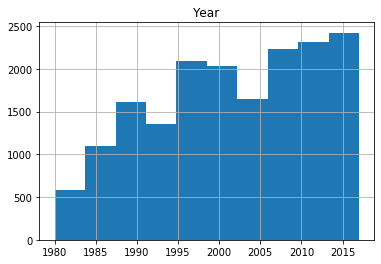

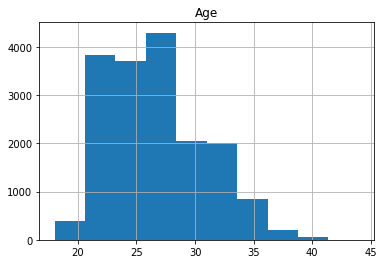

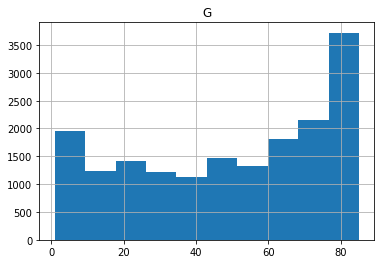

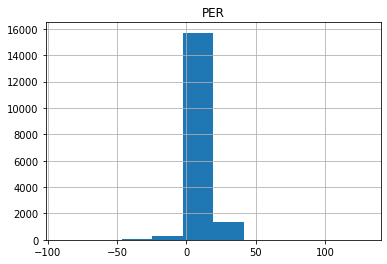

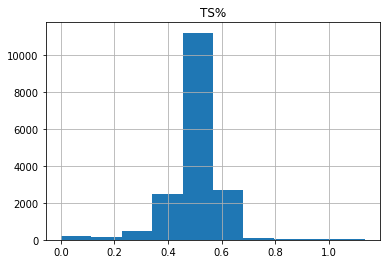

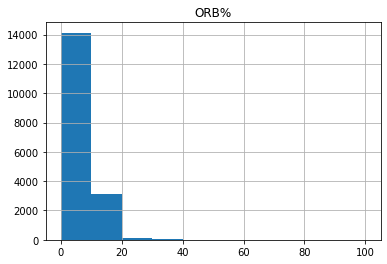

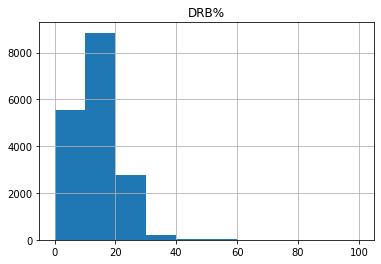

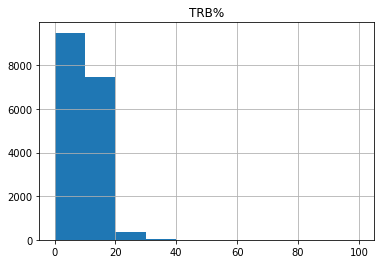

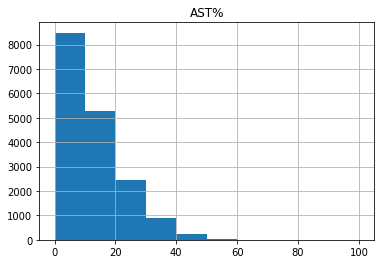

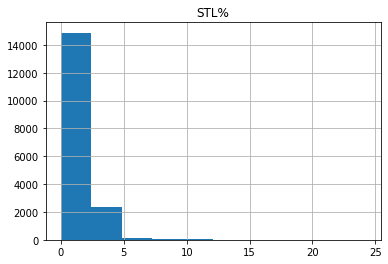

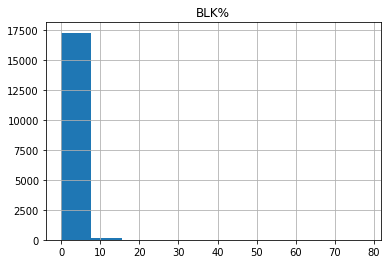

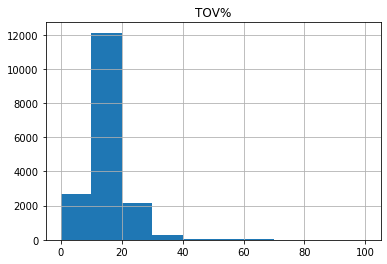

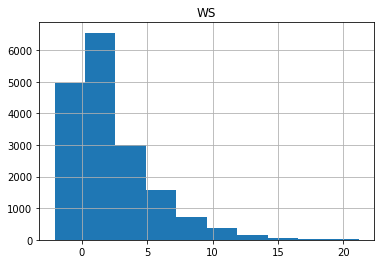

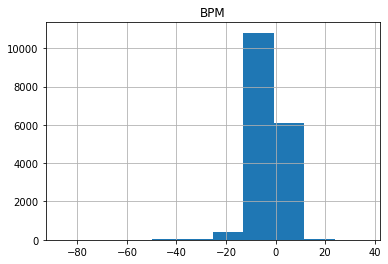

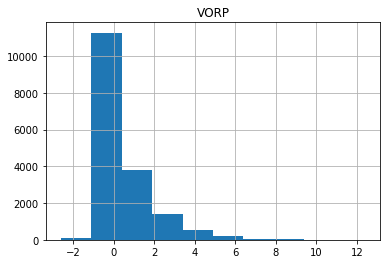

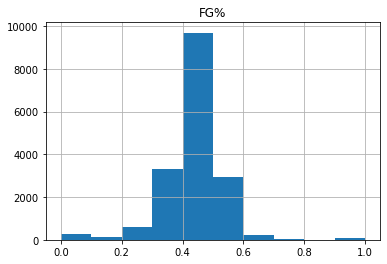

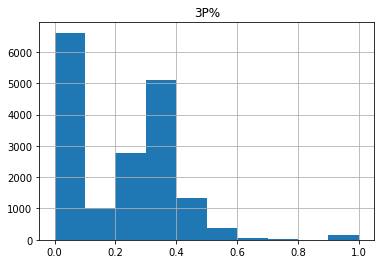

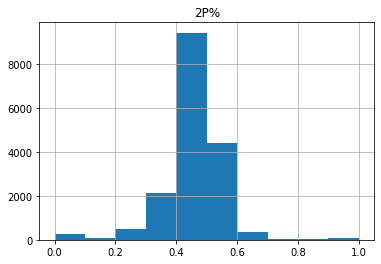

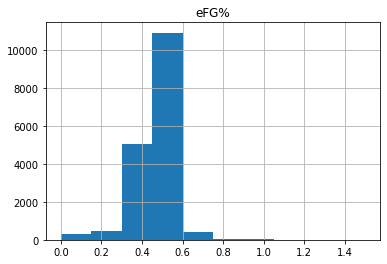

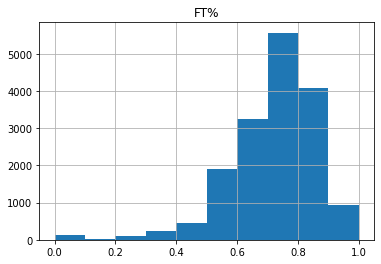

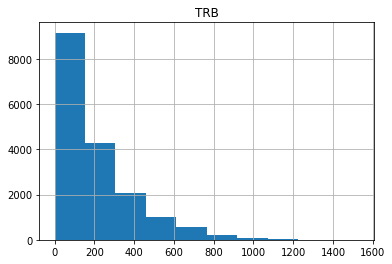

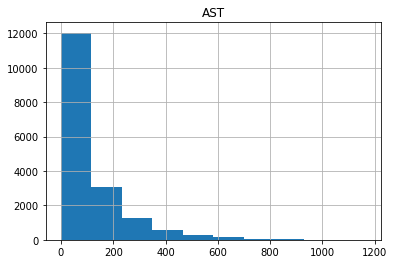

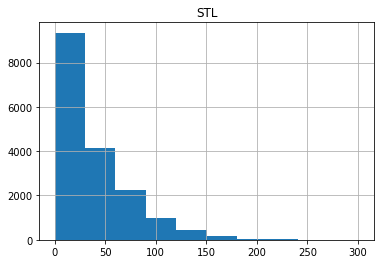

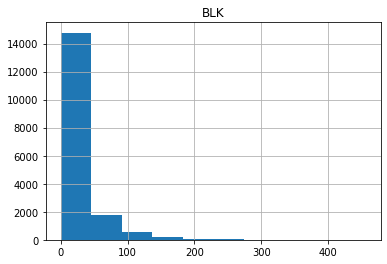

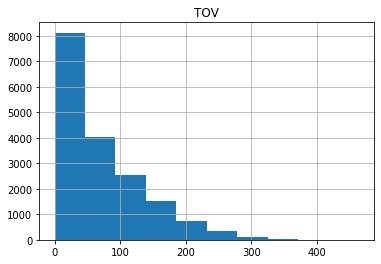

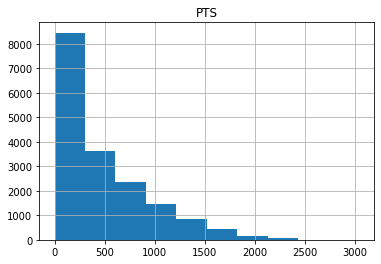

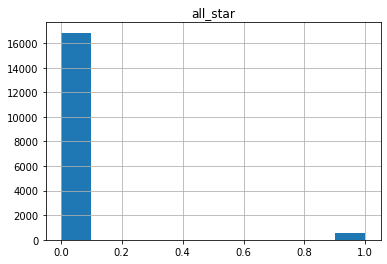

In [19]:
#Checking for distribution of the numerical variables
for i in player_data[numerical_columns]:
    player_data[numerical_columns].hist(i)

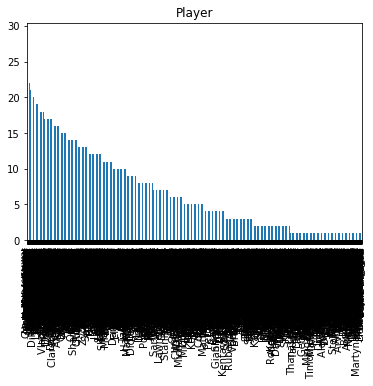

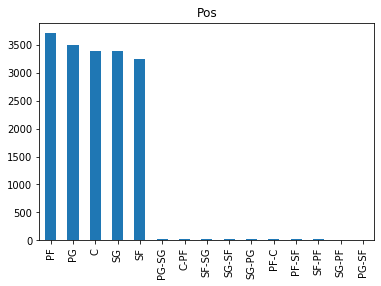

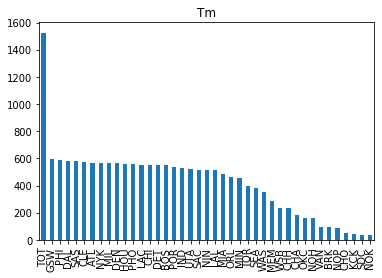

In [20]:
for i in player_data[categorical_columns]:
    player_data[categorical_columns][i].value_counts().plot(kind='bar')
    plt.title(i)
    plt.show()

In [21]:
#Checking for unique values of categorical variables
for i in player_data[categorical_columns]:
    print(i + " " + str(len(player_data[categorical_columns][i].unique())) + " unique values")  

Player 2583 unique values
Pos 15 unique values
Tm 41 unique values


In [65]:
#Checking if the dataset is unbalanced
player_data['all_star'].value_counts()

0    16853
1      555
Name: all_star, dtype: int64

#### Create a corr map of the features

(27.0, 0.0)

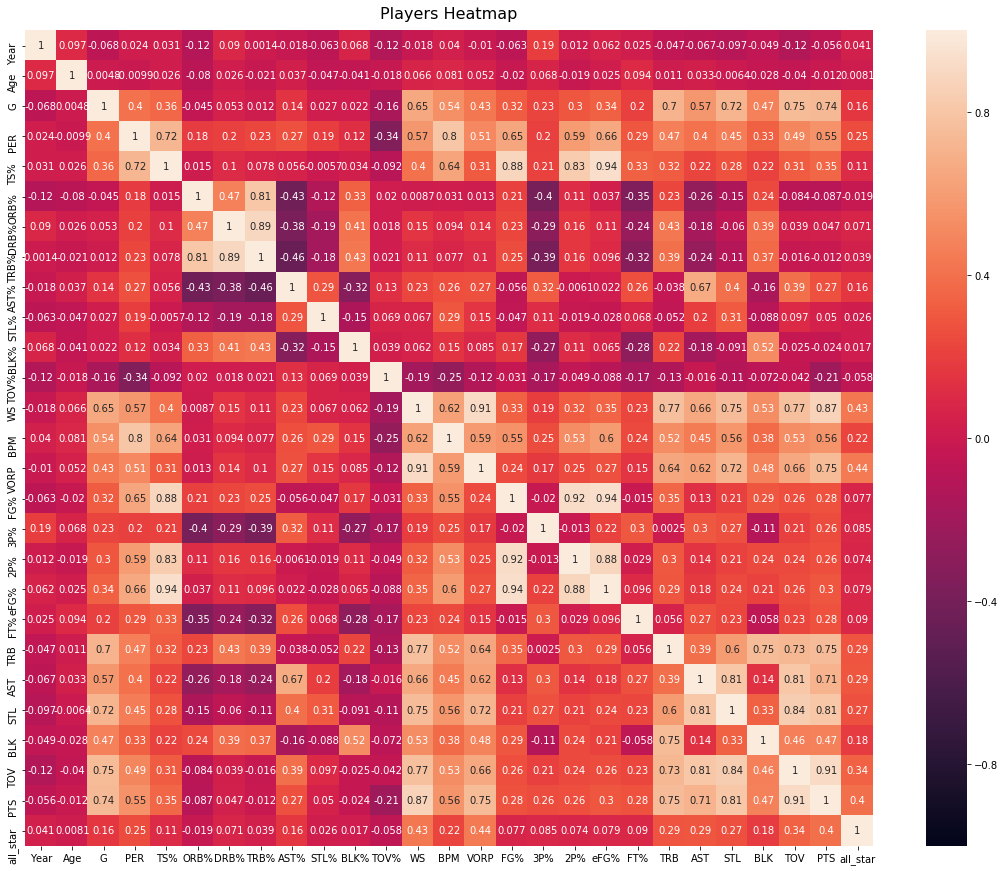

In [22]:
plt.figure(figsize=(19, 15))
heatmap = sns.heatmap(player_data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Players Heatmap', fontdict={'fontsize':16}, pad=12);
bottom, top = heatmap.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5)

#### Graph the distibution of the 'Age' feature

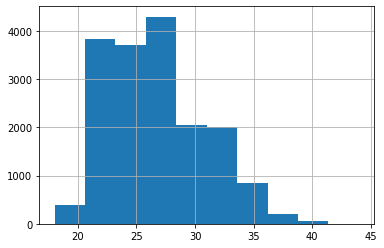

In [23]:
player_data[numerical_columns]['Age'].hist()

## Part 3: Classification

### Build a classifier that predicts whether or not a player makes an All-Star team based on their stats for that season

In [57]:
#This function as its name indicates evaluates the Test and Train accuracy score of a model with CV
scores = []

def evaluate(x_train, y_train, x_test, y_test, estimator, store=True, verbose=False):

    estimator.fit(x_train, y_train)
    accs = cross_val_score(estimator, x_train, y_train, cv=10)
    if verbose is True:
        print('Avg accuracy: {:.3f} +/-{:.3f}'.format(
            np.mean(accs), np.std(accs)))
    train_score = np.mean(accs)
    y_pred = estimator.predict(x_test)
    test_score = estimator.score(x_test, y_test)
    if verbose is True:
        print('Accuracy on test: {:.3f}'.format(test_score))
        print(classification_report(y_test,y_pred))
        print(confusion_matrix(y_test,y_pred))
    if store is True:
        scores.append(test_score)
    return train_score, test_score

In [63]:
# This function is the one used to compare the results of the different models in terms of accuracy in the train and test set
def plot_compare(d, label, new_training_score, new_test_score, ymin=0.5, ymax=0.99):
    d.update({label: [np.median(new_training_score),
                      np.median(new_test_score)]})
    plt.figure(figsize=(9, 7))
    pd.DataFrame(d).set_index([pd.Index(['training', 'test'])]).plot.bar()
    plt.ylim(ymin, ymax)
    plt.show()

In [50]:
classification_results = {}

### Balancing the dataset

In [68]:
# Separate majority and minority classes
df_majority = player_data[player_data['all_star']==0]
df_minority = player_data[player_data['all_star']==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=16853,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
player_data_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [69]:
#Display new class counts
player_data_upsampled['all_star'].value_counts()

1    16853
0    16853
Name: all_star, dtype: int64

### Baseline

In [98]:
player_data_baseline = deepcopy(player_data_upsampled)

In [72]:
#Checking for missing values
player_data_baseline.isnull().sum()

Year          0
Player        0
Pos           0
Age           0
Tm            0
G             0
PER           5
TS%          76
ORB%          5
DRB%          5
TRB%          5
AST%          5
STL%          5
BLK%          5
TOV%         61
WS            0
BPM           0
VORP          0
FG%          88
3P%           0
2P%         116
eFG%         88
FT%         724
TRB           0
AST           0
STL           0
BLK           0
TOV           0
PTS           0
all_star      0
dtype: int64

In [99]:
player_data_baseline.fillna(player_data_baseline.mean(), inplace= True)

In [74]:
player_data_baseline.dtypes

Year        float64
Player       object
Pos          object
Age         float64
Tm           object
G           float64
PER         float64
TS%         float64
ORB%        float64
DRB%        float64
TRB%        float64
AST%        float64
STL%        float64
BLK%        float64
TOV%        float64
WS          float64
BPM         float64
VORP        float64
FG%         float64
3P%         float64
2P%         float64
eFG%        float64
FT%         float64
TRB         float64
AST         float64
STL         float64
BLK         float64
TOV         float64
PTS         float64
all_star      int64
dtype: object

In [100]:
#Encoding categorical variables
categorical_variables = player_data_baseline.select_dtypes(exclude=["number","bool_"]).columns
player_data_baseline = pd.get_dummies(player_data_baseline,prefix=categorical_variables)

In [101]:
#Splitting the data
splits = np.array([0.8, 0.2])

#Shuffle your input
player_data_baseline = player_data_baseline.sample(frac=1)

#Split into 2 parts
player_data_baseline_train, player_data_baseline_test = np.array_split(
    player_data_baseline, (splits[:-1].cumsum() * len(player_data_baseline)).astype(int))

In [102]:
#Creating features and target variables for the train
x_train = player_data_baseline_train.loc[:, player_data_baseline_train.columns != 'all_star']
y_train = player_data_baseline_train['all_star']

#Creating features and target variables for the test
x_test = player_data_baseline_test.loc[:, player_data_baseline_test.columns != 'all_star']
y_test = player_data_baseline_test['all_star']

Avg accuracy: 0.932 +/-0.004
Accuracy on test: 0.926
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      3309
           1       0.90      0.96      0.93      3433

    accuracy                           0.93      6742
   macro avg       0.93      0.92      0.93      6742
weighted avg       0.93      0.93      0.93      6742

[[2936  373]
 [ 129 3304]]


<Figure size 648x504 with 0 Axes>

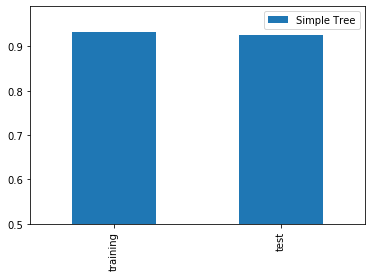

In [78]:
#Defining the model
tree = DecisionTreeClassifier(random_state=0, max_depth=4)

#Using the evaluate function to evaluate the model over our data
tree_train, tree_test =evaluate(x_train, y_train, x_test, y_test, tree, verbose = True)

#Plotting the results of our first model
plot_compare(classification_results, 'Simple Tree', tree_train, tree_test)

### Randome Forest

Avg accuracy: 0.996 +/-0.001
Accuracy on test: 0.997
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3380
           1       0.99      1.00      1.00      3362

    accuracy                           1.00      6742
   macro avg       1.00      1.00      1.00      6742
weighted avg       1.00      1.00      1.00      6742

[[3357   23]
 [   0 3362]]


<Figure size 648x504 with 0 Axes>

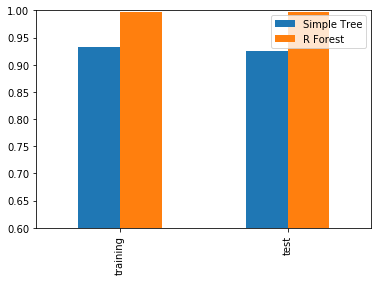

In [92]:
#Defining the model again but this time using Random Forest
rf = RandomForestClassifier(criterion= 'gini',
                                n_estimators=500, 
                                max_features='auto',
                                oob_score = True, 
                                random_state=1
                                )

#Using the evaluate function to evaluate the model over our data
rf_train, rf_test =evaluate(x_train, y_train, x_test, y_test, rf, verbose = True)

#Plotting the results of our new model
plot_compare(classification_results, 'R Forest', rf_train, rf_test, ymin=0.60, ymax=1)

Avg accuracy: 0.992 +/-0.002
Accuracy on test: 0.994
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3380
           1       0.99      1.00      0.99      3362

    accuracy                           0.99      6742
   macro avg       0.99      0.99      0.99      6742
weighted avg       0.99      0.99      0.99      6742

[[3341   39]
 [   0 3362]]


<Figure size 648x504 with 0 Axes>

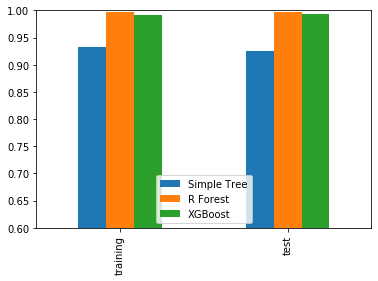

In [96]:
#Defining the model again but this time using XGBoost
xgb = xgb.XGBClassifier(learning_rate=0.1,n_estimators=100,
                                random_state=0,
                                max_depth=20,
                                n_jobs=-1)


#Using the evaluate function to evaluate the model over our data
xgb_train, xgb_test =evaluate(x_train, y_train, x_test, y_test, xgb, verbose = True)

#Plotting the results of our new model
plot_compare(classification_results, 'XGBoost', xgb_train, xgb_test, ymin=0.60, ymax=1)

### NN

In [103]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(2665,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=50, batch_size=1)

test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Train on 26964 samples
Epoch 1/50
26964/26964 [==============================] - 106s 4ms/sample - loss: 7.6970 - accuracy: 0.5010
Epoch 2/50
26964/26964 [==============================] - 106s 4ms/sample - loss: 7.6970 - accuracy: 0.5010
Epoch 3/50
26964/26964 [==============================] - 104s 4ms/sample - loss: 7.6970 - accuracy: 0.5010
Epoch 4/50
26964/26964 [==============================] - 101s 4ms/sample - loss: 7.6970 - accuracy: 0.5010
Epoch 5/50
26964/26964 [==============================] - 112s 4ms/sample - loss: 7.6970 - accuracy: 0.5010
Epoch 6/50
26964/26964 [==============================] - 112s 4ms/sample - loss: 7.6970 - accuracy: 0.5010
Epoch 7/50
26964/26964 [==============================] - 101s 4ms/sample - loss: 7.6970 - accuracy: 0.5010
Epoch 8/50
26964/26964 [==============================] - ETA: 0s - loss: 7.6973 - accuracy: 0.50 - 105s 4ms/sample - loss: 7.6970 - accuracy: 0.5010
Epoch 9/50
26964/26964 [==============================] - 109s 4ms/samp